# Universidad Nacional de Loja
## Evaluacion Unidad 3 - Data Mining
**Jhandry Santiago Chimbo Rivera**


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier


sns.set(style="whitegrid")


In [2]:
# Clase SimuladorDatos
class SimuladorDatos:
    def __init__(self, n=200, seed=42):
        self.n = n
        self.seed = seed
        np.random.seed(self.seed)

    def generar(self, logica_abandono=False):
        edad = np.random.randint(18, 35, size=self.n)
        horas_estudio = np.random.uniform(1, 25, size=self.n)

        promedio_base = 5 + (horas_estudio / 5) - np.random.normal(0, 0.5, self.n)
        promedio = np.clip(promedio_base, 5, 10).round(2)
        
        asistencia_base = 70 + (horas_estudio * 1.2) - (edad * 0.5) + np.random.normal(0, 5, self.n)
        asistencia = np.clip(asistencia_base, 50, 100).round(2)
        
        uso_online = np.random.uniform(0, 15, size=self.n).round(2)

        if logica_abandono:
            abandono = (
                (promedio < 7) | (asistencia < 70) | (horas_estudio < 7)
            ).astype(int)
        else:
            riesgo = (
                -0.4 * (promedio - 7)          
                - 0.08 * (asistencia - 80)    
                - 0.1 * (horas_estudio - 10)   
                + 0.05 * (edad - 22)         
                + np.random.normal(0, 0.5, self.n)
            )
            prob_abandono = 1 / (1 + np.exp(-riesgo))
            abandono = (np.random.rand(self.n) < prob_abandono).astype(int)

        df = pd.DataFrame({
            'Edad': edad,
            'Horas_estudio': horas_estudio.round(2),
            'Asistencia': asistencia,
            'Promedio': promedio,
            'Uso_online': uso_online,
            'Abandono': abandono
        })

        return df

In [3]:
# Clase ModeloAbandono
class ModeloAbandono:
    def __init__(self, max_depth=4, random_state=42):
        self.max_depth = max_depth
        self.random_state = random_state
        self.modelo = DecisionTreeClassifier(max_depth=self.max_depth, random_state=self.random_state)

    def entrenar(self, data):
        self.data = data
        X = data.drop('Abandono', axis=1)
        y = data['Abandono']
        
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y, test_size=0.3, random_state=self.random_state
        )

        # Balanceo con SMOTE
        smote = SMOTE(random_state=self.random_state)
        X_resampled, y_resampled = smote.fit_resample(self.X_train, self.y_train)

        print(f"Datos balanceados: {sum(y_resampled==0)} no abandonan / {sum(y_resampled==1)} abandonan")

        self.modelo.fit(X_resampled, y_resampled)

        # Visualizacion del balanceo de datos
        plt.figure(figsize=(6, 4))
        sns.countplot(x=y_resampled, hue=y_resampled, palette='Set2', legend=False)
        plt.title(" Distribución de datos balanceados")
        plt.xticks([0, 1], ['Continúa', 'Abandona'])
        plt.ylabel("Cantidad")
        plt.xlabel("Estado")
        plt.show()

    def evaluar(self):
        y_pred = self.modelo.predict(self.X_test)
        acc = accuracy_score(self.y_test, y_pred)
        print(f"\n Accuracy del modelo: {acc:.2f}")
        print("\n Reporte de clasificación:\n")
        print(classification_report(self.y_test, y_pred))

        # Visualización del árbol
        plt.figure(figsize=(12, 6))
        plot_tree(self.modelo, feature_names=self.X_train.columns, class_names=["Continúa", "Abandona"], filled=True)
        plt.title(" Árbol de Decisión Entrenado")
        plt.show()

    def predecir_estudiante(self, estudiante_df):
        pred = self.modelo.predict(estudiante_df)[0]
        return "Abandonará" if pred == 1 else "Seguirá estudiando"


In [4]:
# Clase ModeloRandomForest
class ModeloRandomForest:
    def __init__(self, n_estimators=100, max_depth=4, random_state=42):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.random_state = random_state
        self.modelo = RandomForestClassifier(
            n_estimators=self.n_estimators,
            max_depth=self.max_depth,
            random_state=self.random_state
        )

    def entrenar(self, data):
        self.data = data
        X = data.drop('Abandono', axis=1)
        y = data['Abandono']

        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y, test_size=0.3, random_state=self.random_state
        )

        # Balancear con SMOTE
        smote = SMOTE(random_state=self.random_state)
        X_resampled, y_resampled = smote.fit_resample(self.X_train, self.y_train)

        self.modelo.fit(X_resampled, y_resampled)

    def evaluar(self):
        y_pred = self.modelo.predict(self.X_test)
        acc = accuracy_score(self.y_test, y_pred)
        print(f"\n Accuracy del modelo Random Forest: {acc:.2f}")
        print("\n Reporte de clasificación:\n")
        print(classification_report(self.y_test, y_pred))
    
    def predecir_estudiante(self, estudiante_df):
        pred = self.modelo.predict(estudiante_df)[0]
        return "Abandonará" if pred == 1 else "Seguirá estudiando"


In [5]:
# Clase TestBasicoModeloAbandono
class TestBasicoModeloAbandono:
    def ejecutar(self):
        # 1. Generar los datos
        print(" Generando datos simulados...")
        simulador = SimuladorDatos()
        datos = simulador.generar()
        print(datos.head())

        # 2. Entrenar el modelo
        print("\n Entrenando el modelo de abandono...")
        modelo = ModeloAbandono()
        modelo.entrenar(datos)

        # 3. Evaluar el modelo
        print("\n Evaluando el modelo...")
        modelo.evaluar()

        # Comparación con Random Forest
        print(" Random Forest")
        rf_modelo = ModeloRandomForest()
        rf_modelo.entrenar(datos)
        rf_modelo.evaluar()

        # 4. Predecir tres nuevos estudiantes
        print("\n Predicción de nuevos estudiantes:")
        nuevos_estudiantes = pd.DataFrame({
            'Edad': [21, 25, 19],
            'Horas_estudio': [10.5, 5.0, 15.0],
            'Asistencia': [85.0, 60.0, 95.0],
            'Promedio': [8.0, 6.5, 9.0],
            'Uso_online': [6.5, 2.0, 10.0]
        })
        resultados = [modelo.predecir_estudiante(nuevos_estudiantes.iloc[[i]]) for i in range(3)]
        print("\n Predicción de nuevos estudiantes:")
        for i, resultado in enumerate(resultados, 1):
            print(f" Estudiante {i}: {resultado}")
        
        resultados = [rf_modelo.predecir_estudiante(nuevos_estudiantes.iloc[[i]]) for i in range(3)]
        print("\n Predicción de nuevos estudiantes con Random Forest:")
        for i, resultado in enumerate(resultados, 1):
            print(f" Estudiante {i}: {resultado}")


 Generando datos simulados...
   Edad  Horas_estudio  Asistencia  Promedio  Uso_online  Abandono
0    24          17.81       86.09      9.33        1.84         0
1    32          21.32       73.05      9.08       13.15         0
2    28          21.55       94.73      8.74        9.64         0
3    25          10.71       67.23      6.71       10.56         1
4    24          22.31       86.78      9.77       13.66         0

 Entrenando el modelo de abandono...
Datos balanceados: 74 no abandonan / 74 abandonan


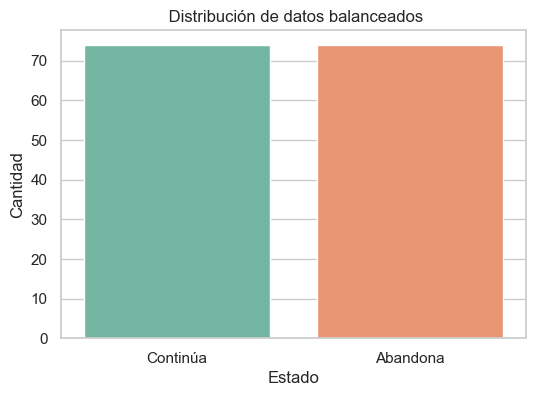


 Evaluando el modelo...

 Accuracy del modelo: 0.85

 Reporte de clasificación:

              precision    recall  f1-score   support

           0       0.81      0.77      0.79        22
           1       0.87      0.89      0.88        38

    accuracy                           0.85        60
   macro avg       0.84      0.83      0.84        60
weighted avg       0.85      0.85      0.85        60



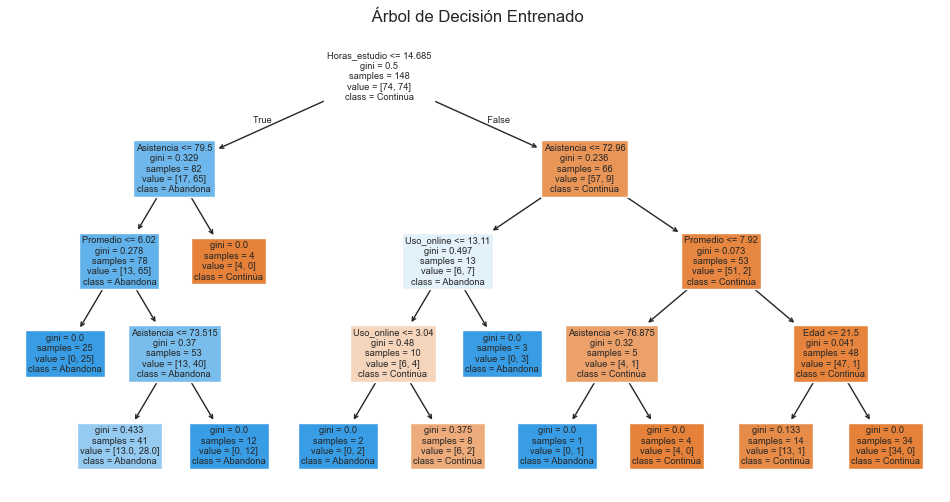

 Random Forest

 Accuracy del modelo Random Forest: 0.87

 Reporte de clasificación:

              precision    recall  f1-score   support

           0       0.82      0.82      0.82        22
           1       0.89      0.89      0.89        38

    accuracy                           0.87        60
   macro avg       0.86      0.86      0.86        60
weighted avg       0.87      0.87      0.87        60


 Predicción de nuevos estudiantes:

 Predicción de nuevos estudiantes:
 Estudiante 1: Seguirá estudiando
 Estudiante 2: Abandonará
 Estudiante 3: Seguirá estudiando

 Predicción de nuevos estudiantes con Random Forest:
 Estudiante 1: Seguirá estudiando
 Estudiante 2: Abandonará
 Estudiante 3: Seguirá estudiando


In [6]:
# Ejecutar todo el flujo
if __name__ == "__main__":
    test = TestBasicoModeloAbandono()
    test.ejecutar()